In [13]:
# Mithil Patel 
# DSC 530 Week 9 Assignment
# 7th August, 2022

# Importing libraries
import thinkstats2
import numpy as np
import nsfg
import pandas as pd
import statsmodels.formula.api as smf
import thinkplot

In [6]:
# Created functions to clear up imported data
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

def GroupByDay(transactions, func=np.mean):
    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)

    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

# importing data from excel
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
dailies = GroupByQualityAndDay(transactions)

In [8]:
# Quadratic model
def RunQuadraticModel(daily):
    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

daily = dailies["high"]

# calling the quadratic function
model, results = RunQuadraticModel(daily)

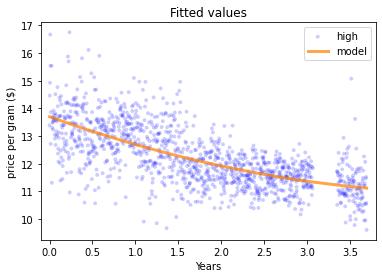

In [25]:
# Plotting quadratic plot
def PlotFittedValues(model, results, label=""):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")
PlotFittedValues(model, results, label="high")
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="price per gram ($)"
)

In [26]:
# Supporting functions to create a predictive model
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

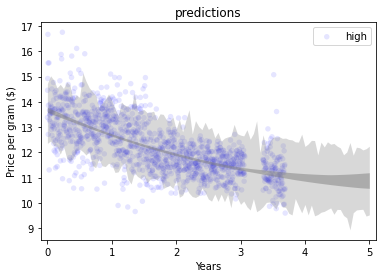

In [ ]:
# Plotting the prediction model
def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")
    
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label="high")
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title="predictions", xlabel="Years", xlim=[years[0] - 0.1, years[-1] + 0.1], 
                 ylabel="Price per gram ($)",)


Problem 12.2

In [28]:
# function for serial correlations by permutation
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

# creating linear model 
def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [31]:
# Testing serial correlation

# Testing using raw data 
series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(f"raw data test: {test.actual}, p-val: {pvalue}")

# Testing for linear model
_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(f"Linear model test: {test.actual}, p-val: {pvalue}")

# Testing for quadratic model
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(f"Quadratic model test: {test.actual}, p-val: {pvalue}")

raw data test: 0.4852293761947381, p-val: 0.0
Linear model test: 0.07570473767506267, p-val: 0.004
Quadratic model test: 0.05607308161289924, p-val: 0.052
